In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 8)
plt.style.use('ggplot')

np.set_printoptions(precision=3)
pd.set_option('precision', 3)
pd.set_option('display.max_columns', None)
sns.set(font_scale=1.2)

In [2]:
import cv2
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, Input, Dropout, Flatten, Dense, MaxPooling2D

# Problem 1: CNN classificaiton

###### Construct a CNN to classify the images in the MRI dataset. 

In [5]:
mri_dir = 'E:/Math/NEU/MATH7243/Labs/MRI_Images/'
mri_labels_path = mri_dir + 'labels-1.csv'

In [6]:
mri_labels = pd.read_csv(mri_labels_path, index_col=0)
print(mri_labels.shape)
print('MRI labels value counts')
print(mri_labels['Slice'].value_counts())
mri_labels.head()

(609, 14)
MRI labels value counts
180    203
120    203
55     203
Name: Slice, dtype: int64


,Filename,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Slice
0,OAS1_0001_MR1_55.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,55
1,OAS1_0001_MR1_120.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,120
2,OAS1_0001_MR1_180.png,OAS1_0001_MR1,F,R,74,2,3.0,29,0.0,1344,0.743,1.306,NaN,180
3,OAS1_0002_MR1_55.png,OAS1_0002_MR1,F,R,55,4,1.0,29,0.0,1147,0.810,1.531,NaN,55
4,OAS1_0002_MR1_120.png,OAS1_0002_MR1,F,R,55,4,1.0,29,0.0,1147,0.810,1.531,NaN,120


In [7]:
mri_labels['Slice'] = mri_labels['Slice'].astype(str)

image shape is: (176, 176, 3)


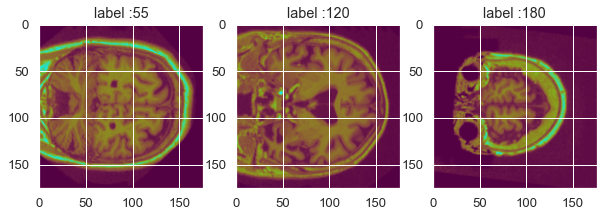

In [8]:
## randomly select elemest from different labels
unique_labels = mri_labels['Slice'].unique()
fig, ax = plt.subplots(1, len(unique_labels), figsize=(10, 10*len(unique_labels)))
for i, label in enumerate(unique_labels):
    filename =  mri_labels[mri_labels['Slice'] == label]['Filename'].sample().values[0]
    img = cv2.imread(mri_dir + filename)
    ax[i].imshow(img)
    ax[i].set_title(f'label :{label}')
print(f'image shape is: {img.shape}')

In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_ds = datagen.flow_from_dataframe(dataframe=mri_labels, directory=mri_dir, x_col='Filename', y_col='Slice', 
                                       subset='training', batch_size=16, seed=7, shuffle=True, color_mode='rgb',
                                       class_mode='categorical', target_size=(176, 176))
val_ds = datagen.flow_from_dataframe(dataframe=mri_labels, directory=mri_dir, x_col='Filename', y_col='Slice', 
                                       subset='validation', batch_size=16, seed=7, shuffle=True, color_mode='rgb',
                                       class_mode='categorical', target_size=(176, 176))

Found 488 validated image filenames belonging to 3 classes.
Found 121 validated image filenames belonging to 3 classes.


In [10]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(176, 176, 3)))
model.add(Conv2D(40, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(48, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(56, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 174, 174, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 172, 172, 40)      11560     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 86, 86, 40)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 84, 84, 48)        17328     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 48)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 56)        2

In [11]:
STEP_SIZE_TRAIN = train_ds.n//train_ds.batch_size
STEP_SIZE_VAL = val_ds.n//val_ds.batch_size

early_stopping = tf.keras.callbacks.EarlyStopping(min_delta=1e-3, patience=3)
checkpoint = tf.keras.callbacks.ModelCheckpoint('./mri_model.h5', verbose=2, save_best_only=True)

history = model.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_ds, validation_steps=STEP_SIZE_VAL, epochs=7)

Epoch 1/7
30/30 [==============================] - 83s 3s/step - loss: 5.2081 - accuracy: 0.8178 - val_loss: 0.0982 - val_accuracy: 0.9643
Epoch 2/7
30/30 [==============================] - 81s 3s/step - loss: 0.0207 - accuracy: 0.9936 - val_loss: 0.1300 - val_accuracy: 0.9732
Epoch 3/7
30/30 [==============================] - 77s 3s/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0968 - val_accuracy: 0.9911
Epoch 4/7
30/30 [==============================] - 66s 2s/step - loss: 4.9104e-04 - accuracy: 1.0000 - val_loss: 0.1094 - val_accuracy: 0.9911
Epoch 5/7
30/30 [==============================] - 54s 2s/step - loss: 1.5016e-04 - accuracy: 1.0000 - val_loss: 0.0960 - val_accuracy: 0.9911
Epoch 6/7
30/30 [==============================] - 58s 2s/step - loss: 5.0725e-05 - accuracy: 1.0000 - val_loss: 0.0971 - val_accuracy: 0.9911
Epoch 7/7
30/30 [==============================] - 59s 2s/step - loss: 3.6316e-05 - accuracy: 1.0000 - val_loss: 0.0970 - val_accuracy: 0.9911


Plots for Loss and Accuracy of training:


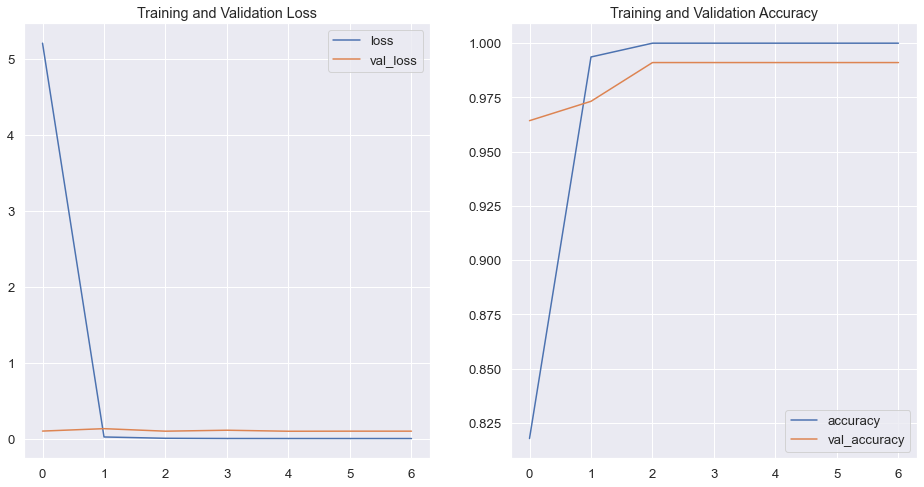

In [12]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[0].set_title('Training and Validation Loss')
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()
    ax[1].set_title('Training and Validation Accuracy')
    print('Plots for Loss and Accuracy of training:')
    
plot_loss_acc(history)

# Problem 2: Pretrained Networks



##### Construct a CNN using the Pretrained Network to classify the images in the MRI dataset.

In [13]:
n_classes = 3

base_model = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.summary()

58900480/58889256 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.01)
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [16]:
history = model.fit(train_ds, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_ds, validation_steps=STEP_SIZE_VAL, epochs=5)

Epoch 1/5
30/30 [==============================] - 161s 5s/step - loss: 2.1911 - accuracy: 0.4555 - val_loss: 0.2826 - val_accuracy: 0.8482
Epoch 2/5
30/30 [==============================] - 201s 7s/step - loss: 0.2446 - accuracy: 0.9195 - val_loss: 0.0376 - val_accuracy: 1.0000
Epoch 3/5
30/30 [==============================] - 161s 5s/step - loss: 0.0775 - accuracy: 0.9788 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 4/5
30/30 [==============================] - 184s 6s/step - loss: 0.0443 - accuracy: 0.9894 - val_loss: 0.0129 - val_accuracy: 1.0000
Epoch 5/5
30/30 [==============================] - 202s 7s/step - loss: 0.0297 - accuracy: 0.9915 - val_loss: 0.0091 - val_accuracy: 1.0000


Plots for Loss and Accuracy of training:


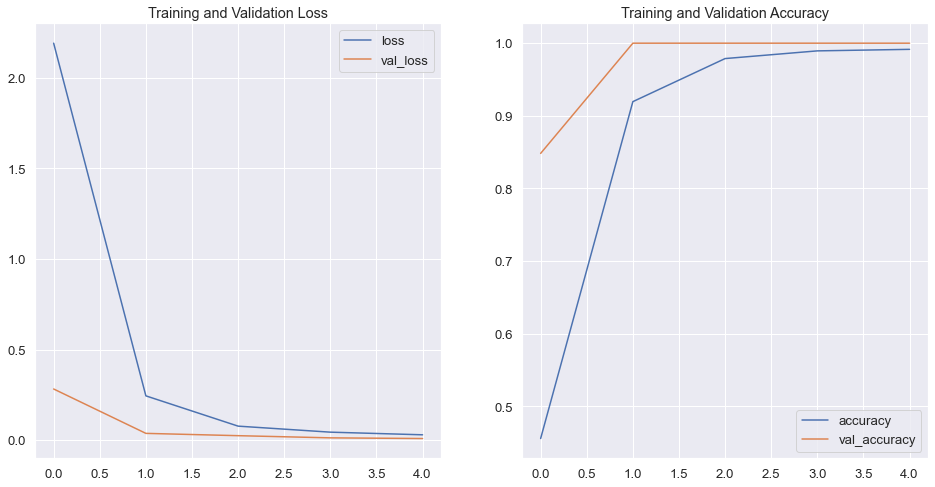

In [17]:
plot_loss_acc(history=history)